In [2]:
!pip install qiskit --quiet
!pip install qiskit-ibm-runtime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.3/341.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.0 MB/s eta 0:00:00


In [9]:
!pip install pylatexenc

In [3]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [20]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
service = QiskitRuntimeService(token="2c1b929fb077adfd5e316ecce95d257e4c17085ba8643826ee0460dfd2f0ad0193e599a85c792de61f9538d3436ace8e4fd586782209ed6035ca29cb54481f7c", channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

In [28]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

Oracle

In [44]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw()

<ipython-input-28-6de8e9ca2dbc>:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


1-Z ┌───┐ 1-Z ┌───┐
q_0: ───────■──┤ X ├──■──┤ X ├
            │  ├───┤  │  ├───┤
q_1: ───────■──┤ X ├──■──┤ X ├
     ┌───┐  │  ├───┤  │  └───┘
q_2: ┤ X ├──■──┤ X ├──■───────
     └───┘     └───┘

Diffuser

In [45]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw()

global phase: π
               1-Z ┌───┐ 1-Z ┌───┐┌───┐┌───┐     ┌───┐┌───┐     
state_0: ───────■──┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
                │  ├───┤  │  ├───┤├───┤├───┤  │  ├───┤├───┤     
state_1: ───────■──┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
         ┌───┐  │  ├───┤  │  ├───┤├───┤├───┤┌─┴─┐├───┤├───┤┌───┐
state_2: ┤ X ├──■──┤ X ├──■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
         └───┘     └───┘     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [46]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

In [47]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw()

┌───┐┌────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0   ├─░─┤M├──────
        ├───┤│    │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 Q ├─░──╫─┤M├───
        ├───┤│    │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2   ├─░──╫──╫─┤M├
        └───┘└────┘ ░  ║  ║ └╥┘
meas: 3/═══════════════╩══╩══╩═
                       0  1  2

In [48]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw()

global phase: 11π/8
                                                                  »
    ancilla_0 -> 0 ───────────────────────────────────────────────»
                                                                  »
    ancilla_1 -> 1 ───────────────────────────────────────────────»
                                                                  »
    ancilla_2 -> 2 ───────────────────────────────────────────────»
                                                                  »
    ancilla_3 -> 3 ───────────────────────────────────────────────»
                   ┌─────────┐ ┌────┐                             »
          q_0 -> 4 ┤ Rz(π/2) ├─┤ √X ├─────────────────────────────»
                   ├─────────┴┐├────┤  ┌──────────┐ ┌──────┐┌────┐»
          q_2 -> 5 ┤ Rz(-π/2) ├┤ √X ├──┤ Rz(-π/2) ├─┤1     ├┤ √X ├»
                   ├─────────┬┘├────┤┌─┴──────────┴┐│  Ecr │├───┬┘»
          q_1 -> 6 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-2.3792) ├┤0     ├┤ X ├─»
                   └─────────┘ └────┘└─────────────┘└──────┘└───┘ »
    ancilla_4 -> 7 ───────────────────────────────────────────────»
                                                                  »
    ancilla_5 -> 8 ───────────────────────────────────────────────»
                                                                  »
    ancilla_6 -> 9 ───────────────────────────────────────────────»
                                                                  »
   ancilla_7 -> 10 ───────────────────────────────────────────────»
                                                                  »
   ancilla_8 -> 11 ───────────────────────────────────────────────»
                                                                  »
   ancilla_9 -> 12 ───────────────────────────────────────────────»
                                                                  »
  ancilla_10 -> 13 ───────────────────────────────────────────────»
                                                                  »
  ancilla_11 -> 14 ───────────────────────────────────────────────»
                                                                  »
  ancilla_12 -> 15 ───────────────────────────────────────────────»
                                                                  »
  ancilla_13 -> 16 ───────────────────────────────────────────────»
                                                                  »
  ancilla_14 -> 17 ───────────────────────────────────────────────»
                                                                  »
  ancilla_15 -> 18 ───────────────────────────────────────────────»
                                                                  »
  ancilla_16 -> 19 ───────────────────────────────────────────────»
                                                                  »
  ancilla_17 -> 20 ───────────────────────────────────────────────»
                                                                  »
  ancilla_18 -> 21 ───────────────────────────────────────────────»
                                                                  »
  ancilla_19 -> 22 ───────────────────────────────────────────────»
                                                                  »
  ancilla_20 -> 23 ───────────────────────────────────────────────»
                                                                  »
  ancilla_21 -> 24 ───────────────────────────────────────────────»
                                                                  »
  ancilla_22 -> 25 ───────────────────────────────────────────────»
                                                                  »
  ancilla_23 -> 26 ───────────────────────────────────────────────»
                                                                  »
  ancilla_24 -> 27 ───────────────────────────────────────────────»
                                                                  »
  ancilla_25 -> 28 ───────────────────────────────────────────────»
                                    

In [50]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

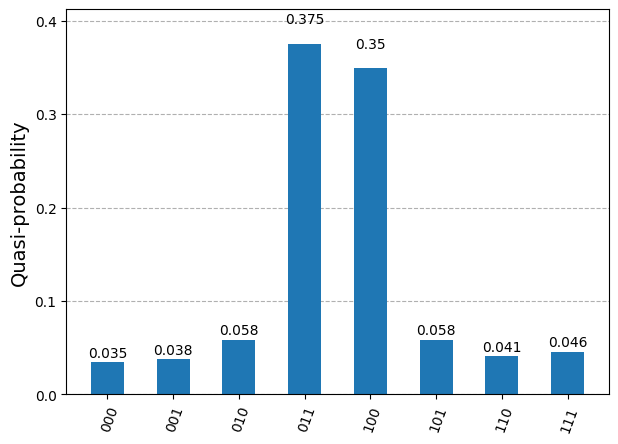

In [51]:
plot_distribution(dist)